# Comparação de Modelos (Artefatos)
Este notebook não treina modelos. Ele apenas carrega os artefatos gerados para reproduzir as métricas, rankings e testes estatísticos do projeto.

- `seaborn` e `matplotlib`: Bibliotecas para visualização dos resultados.
- `scikit-posthocs`: Biblioteca para testes estatísticos pós-hoc.

In [8]:
%pip install --quiet pandas==1.5.3 numpy==1.24.4 matplotlib==3.7.5\
    seaborn==0.13.2 scikit-posthocs==0.7.0 scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Configuração do ambiente


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy.stats as stats
from pathlib import Path
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix
from artifact_utils import load_artifact_bundle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


## Carregando os artefatos salvos
Agrupa todos os bundles por modelo e por dataset. Caso algum par esteja ausente,
um aviso é exibido e o dataset é ignorado nos cálculos.


In [ ]:
MODEL_LABELS = {
    'saint': 'SAINT',
    'lightgbm': 'LightGBM',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost',
    'autogluon': 'AutoGluon',
    'askl2': 'ASKL 2.0'
}


def g_mean_multiclass(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calcula a G-Mean (Média Geométrica) para problemas de classificação multiclasse.
    A G-Mean é a raiz n-ésima do produto dos recalls (sensibilidade) de cada classe.

    Por que é útil?
    -------------
    É uma métrica robusta para datasets desbalanceados. Diferente da acurácia, que pode ser 
    alta apenas acertando a classe majoritária, a G-Mean penaliza severamente o modelo 
    se ele tiver um desempenho ruim em qualquer uma das classes (recall baixo), 
    forçando o equilíbrio entre as classes.

    Args:
        y_true: Array com os rótulos verdadeiros.
        y_pred: Array com os rótulos preditos pelo modelo.

    Returns:
        float: Valor da G-Mean entre 0.0 e 1.0. Retorna 0.0 se houver erro.
    """
    try:
        cm = confusion_matrix(y_true, y_pred)
        row_sums = np.sum(cm, axis=1)
        mask = row_sums > 0
        recalls = np.diag(cm)[mask] / row_sums[mask]
        if len(recalls) == 0:
            return 0.0
        return np.prod(recalls) ** (1.0 / len(recalls))
    except Exception:
        return 0.0


def get_auc_ovo(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a AUC OVO (One-vs-One) para problemas multiclasse.
	
	Por que é útil?
	-------------
	A AUC OVO é uma métrica robusta para avaliar o desempenho de classificadores 
	em problemas multiclasse, especialmente quando as classes são desbalanceadas. 
	Ela considera todas as combinações possíveis de pares de classes, fornecendo 
	uma visão abrangente da capacidade do modelo em distinguir entre diferentes classes.

	Args:
		y_true: Rótulos verdadeiros.
		y_prob: Probabilidades preditas para cada classe.

	Returns:
		float: Valor da AUC OVO entre 0.0 e 1.0. Retorna np.nan se houver erro.
	"""
	try:
		n_classes = len(np.unique(y_true))
		if n_classes == 2:
			if y_prob.ndim == 2 and y_prob.shape[1] == 2:
				return roc_auc_score(y_true, y_prob[:, 1])
			return roc_auc_score(y_true, y_prob)
		return roc_auc_score(y_true, y_prob, multi_class='ovo')
	except Exception:
		return np.nan


bundles_by_model = {
    key: load_artifact_bundle(key)
    for key in MODEL_LABELS
}

evaluation_rows = []
missing_models = []

for model_key, bundles in bundles_by_model.items():
    model_label = MODEL_LABELS.get(model_key, model_key.upper())
    if not bundles:
        missing_models.append(model_label)
        continue

    for bundle in bundles:
        arrays = bundle.arrays
        y_true = arrays['y_true']
        y_pred = arrays.get('y_pred')
        y_prob = arrays.get('y_prob')

		# 1. Acurácia
        acc = accuracy_score(y_true, y_pred) if y_pred is not None else np.nan

		# 2. G-Mean
        gmean = g_mean_multiclass(y_true, y_pred) if y_pred is not None else np.nan

		# 3. AUC OVO
        auc = get_auc_ovo(y_true, y_prob) if y_prob is not None else np.nan

		# 4. Cross-Entropy (Log Loss)
        try:
            ce = log_loss(y_true, y_prob) if y_prob is not None else np.nan
        except Exception:
            ce = np.nan

        runtime = bundle.metadata.get('runtime_seconds', np.nan)
        metrics_meta = bundle.metadata.get('metrics', {})

        evaluation_rows.append({
            'Dataset': bundle.dataset_name,
            'Dataset Slug': bundle.dataset_slug,
            'Model Key': model_key,
            'Model': model_label,
            'AUC_OVO': auc,
            'Accuracy': acc,
            'G-Mean': gmean,
            'Cross_Entropy': ce,
            'Time (s)': runtime,
            'CV Score': metrics_meta.get('cv_accuracy'),
            'Test Score': metrics_meta.get('test_accuracy')
        })

if missing_models:
    print('⚠ Nenhum artefato encontrado para:')
    for model_name in missing_models:
        print(f"  - {model_name}")
else:
    print('✓ Artefatos encontrados para todos os modelos configurados.')

if evaluation_rows:
    results_df = pd.DataFrame(evaluation_rows)
    results_df.to_csv('evaluation_results.csv', index=False)
    print("Resultados salvos em 'evaluation_results.csv'.")
else:
    results_df = pd.DataFrame()
    print('Nenhum resultado disponível. Verifique os diretórios de artefatos.')


✓ Artefatos encontrados para todos os modelos configurados.
Resultados salvos em 'evaluation_results.csv'.


## Médias por modelo


In [11]:
if results_df.empty:
    print('Sem resultados para resumir.')
else:
    cols = ['AUC_OVO', 'Accuracy', 'G-Mean', 'Cross_Entropy', 'Time (s)']
    display(results_df.groupby('Model')[cols].mean())


,AUC_OVO,Accuracy,G-Mean,Cross_Entropy,Time (s)
Model,,,,,
ASKL 2.0,0.877415,0.834175,0.755559,0.426855,358.776557
AutoGluon,0.851959,0.815524,0.587099,0.516461,6.296668
CatBoost,0.868195,0.824005,0.568308,0.417151,46.831890
LightGBM,0.868667,0.830138,0.639121,0.412860,7.372108
SAINT,0.825899,0.789601,0.400588,0.668751,122.461544
XGBoost,0.859560,0.828301,0.706540,0.470682,10.878026


## Visualização comparativa dos modelos

1. **Painel de Métricas**: barras com média e desvio-padrão de cada métrica por modelo.
2. **Heatmaps de Rankings**: posições relativas dos modelos em cada dataset, por métrica.

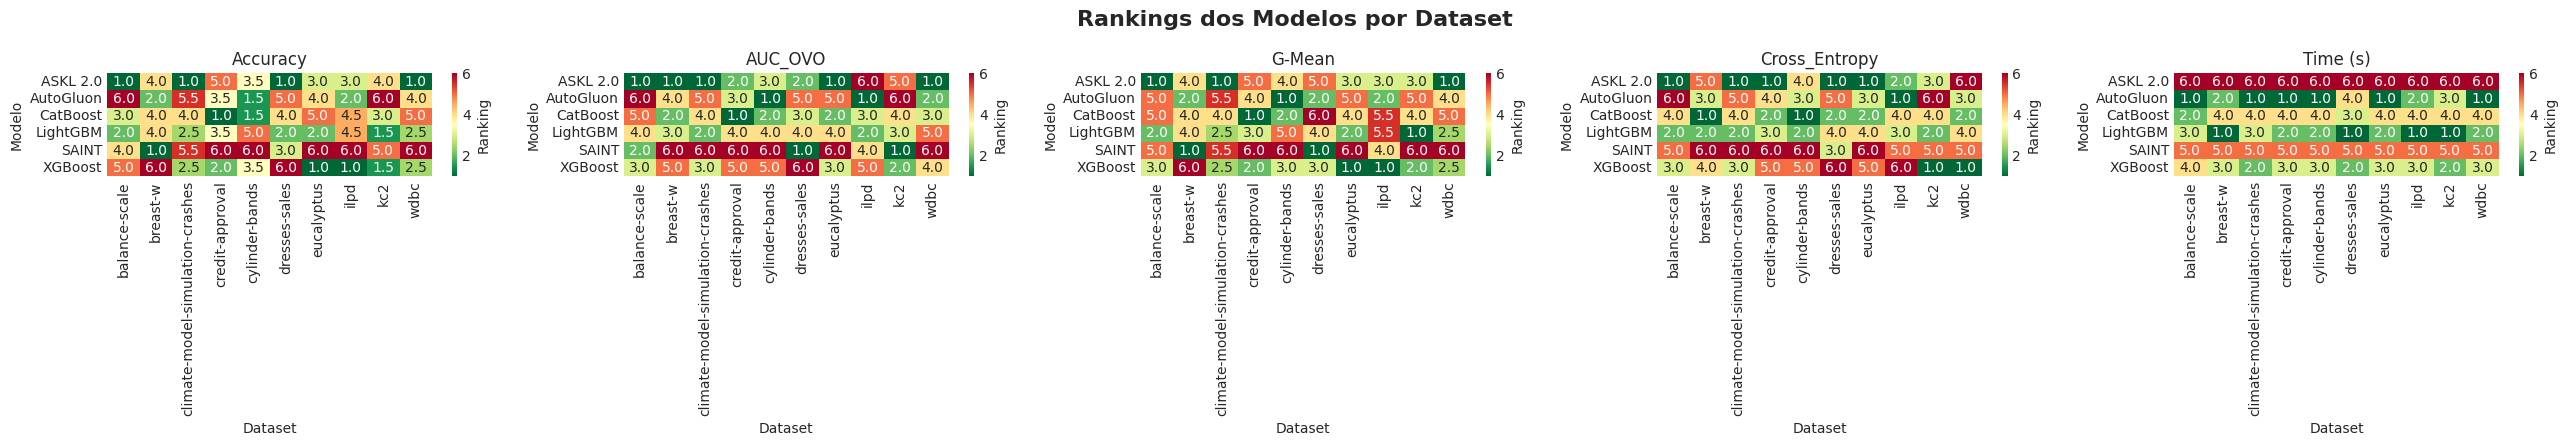

In [12]:
ranking_metrics = [
    ('Accuracy', True),
    ('AUC_OVO', True),
    ('G-Mean', True),
    ('Cross_Entropy', False),
    ('Time (s)', False)
]

if results_df.empty:
    print('⚠ Resultados indisponíveis. Execute a célula de carregamento primeiro.')
else:
    valid_datasets = results_df['Dataset'].nunique()
    if valid_datasets == 0:
        print('Nenhum dataset disponível para ranqueamento.')
    else:
        fig, axes = plt.subplots(1, len(ranking_metrics), figsize=(5.2 * len(ranking_metrics), 4.5))
        fig.suptitle('Rankings dos Modelos por Dataset', fontsize=16, fontweight='bold')

        for ax, (metric, maximize) in zip(np.atleast_1d(axes), ranking_metrics):
            pivot = results_df.pivot(index='Dataset', columns='Model', values=metric).dropna()
            if pivot.empty:
                ax.set_axis_off()
                ax.set_title(f'Sem dados: {metric}')
                continue

            ranks = pivot.apply(lambda row: (-row).rank() if maximize else row.rank(), axis=1)
            sns.heatmap(
                ranks.T,
                annot=True,
                fmt='.1f',
                cmap='RdYlGn_r',
                ax=ax,
                cbar_kws={'label': 'Ranking'}
            )
            ax.set_title(metric)
            ax.set_xlabel('Dataset')
            ax.set_ylabel('Modelo')

        plt.tight_layout()
        plt.show()


## Painel de métricas


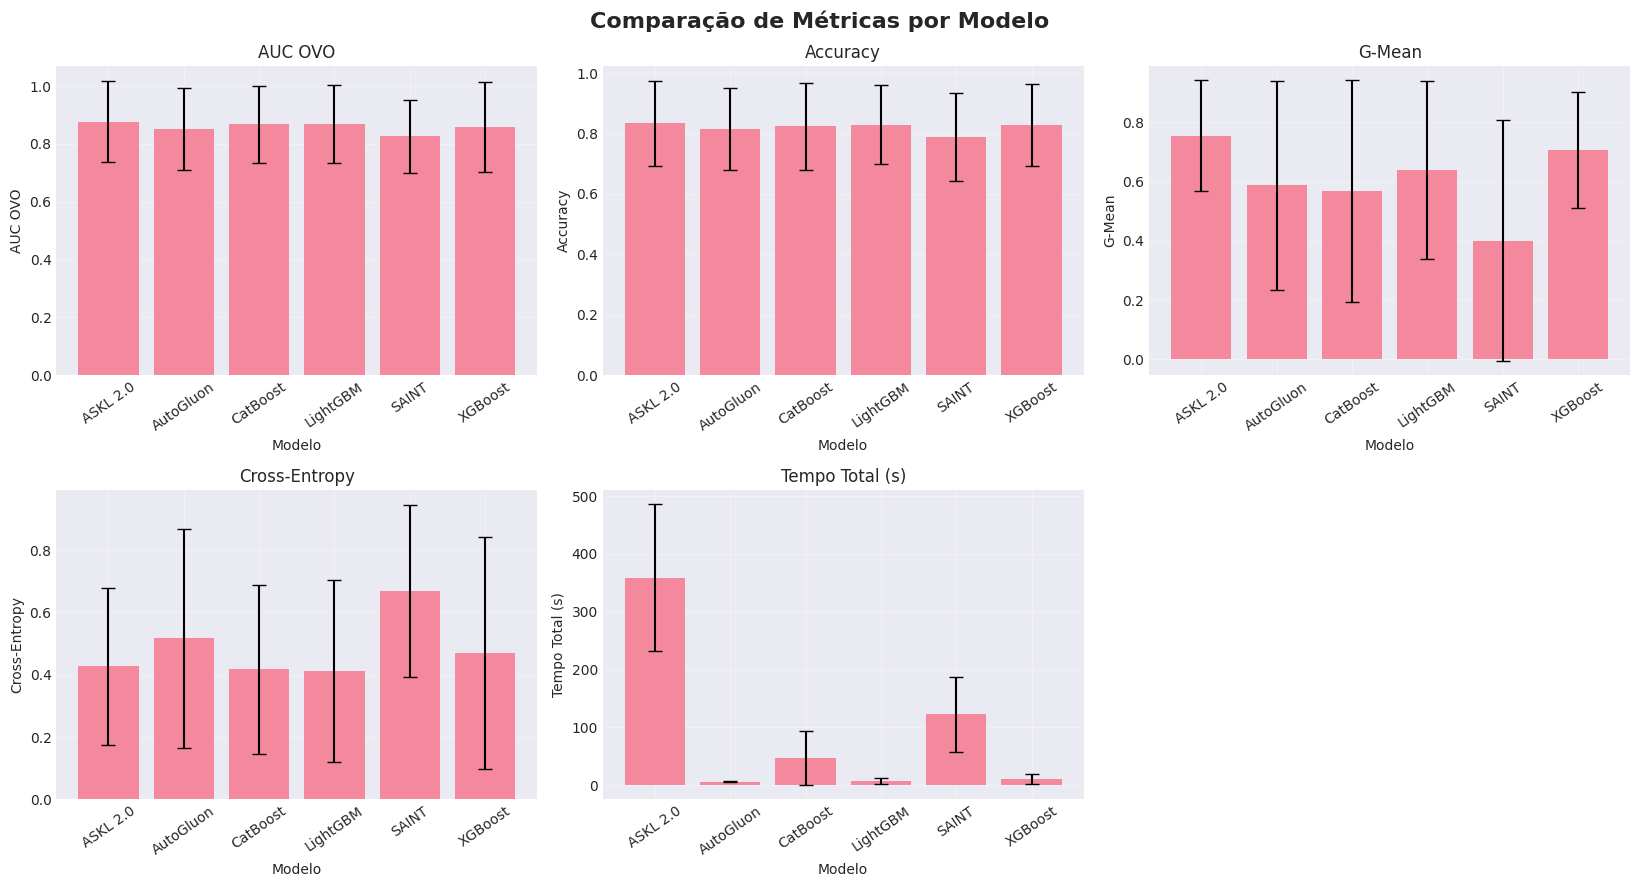

In [13]:
metric_panels = [
    ('AUC_OVO', 'AUC OVO'),
    ('Accuracy', 'Accuracy'),
    ('G-Mean', 'G-Mean'),
    ('Cross_Entropy', 'Cross-Entropy'),
    ('Time (s)', 'Tempo Total (s)')
]

if results_df.empty:
    print('⚠ Resultados indisponíveis. Execute a célula de carregamento primeiro.')
else:
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5))
    fig.suptitle('Comparação de Métricas por Modelo', fontsize=16, fontweight='bold')

    for idx, (metric, title) in enumerate(metric_panels):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        data = results_df.groupby('Model')[metric].agg(['mean', 'std']).reset_index()
        ax.bar(data['Model'], data['mean'], yerr=data['std'], capsize=5, alpha=0.8)
        ax.set_title(title)
        ax.set_ylabel(title)
        ax.set_xlabel('Modelo')
        ax.tick_params(axis='x', rotation=35)
        ax.grid(True, alpha=0.3)

    # remover subplot vazio
    if len(metric_panels) < rows * cols:
        for k in range(len(metric_panels), rows * cols):
            fig.delaxes(axes.flatten()[k])

    plt.tight_layout()
    plt.show()


## Análise estatística (protocolo de Demšar)

Baseado no artigo *"Statistical Comparisons of Classifiers over Multiple Data Sets"*, realizamos a comparação estatística dos modelos seguindo o protocolo recomendado para múltiplos classificadores em múltiplos datasets:

1.  **Ranking:** Calculamos o posto (rank) de cada modelo para cada dataset.
2.  **Teste de Friedman (Iman-Davenport):** Verificamos se existe diferença significativa global entre os algoritmos.
    *   Hipótese Nula ($H_0$): Todos os algoritmos têm desempenho equivalente.
3.  **Teste de Nemenyi (Post-hoc):** Se $H_0$ for rejeitada, calculamos a Diferença Crítica (CD).
    *   Dois algoritmos são significativamente diferentes se a distância entre seus ranks médios for maior que a CD.
4.  **Visualização (CD Diagram):** Plotamos os ranks médios e conectamos modelos estatisticamente equivalentes.


ANÁLISE ESTATÍSTICA BASEADA NO PROTOCOLO DE DEMŠAR (2006)

############################################################
ANÁLISE ESTATÍSTICA: Accuracy
############################################################
Estatística χ²: 9.4970
p-value: 9.0807e-02
✗ FALHA AO REJEITAR H0 (p >= 0.05): Não há evidência suficiente de diferença.

Ranks Médios (1 = melhor):
  1. ASKL 2.0        → Rank Médio: 2.65
  2. LightGBM        → Rank Médio: 2.95
  3. XGBoost         → Rank Médio: 3.10
  4. CatBoost        → Rank Médio: 3.50
  5. AutoGluon       → Rank Médio: 3.95
  6. SAINT           → Rank Médio: 4.85

Teste post-hoc não executado (Friedman não rejeitou H0).

############################################################
ANÁLISE ESTATÍSTICA: AUC_OVO
############################################################
Estatística χ²: 8.7429
p-value: 1.1977e-01
✗ FALHA AO REJEITAR H0 (p >= 0.05): Não há evidência suficiente de diferença.

Ranks Médios (1 = melhor):
  1. ASKL 2.0        → Rank Médio: 2.30


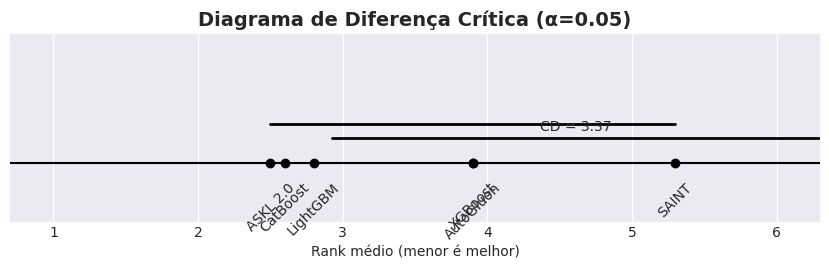

In [ ]:
def plot_cd_diagram(avg_ranks: pd.Series, nemenyi_result: pd.DataFrame, dataset_count: int, alpha: float = 0.05) -> None:
    """Render a Demšar-style critical difference diagram using average ranks and Nemenyi p-values."""
    model_names = avg_ranks.index.tolist()
    k = len(model_names)
    if dataset_count is None or dataset_count < 2:
        print('CD diagram requer pelo menos dois datasets válidos. Gráfico omitido.')
        return

    q_alpha = stats.studentized_range.ppf(1 - alpha, k, np.inf)
    cd_value = q_alpha * np.sqrt(k * (k + 1) / (6.0 * dataset_count))

    fig, ax = plt.subplots(figsize=(max(6, 1.4 * k), 2.8))
    axis_margin = 0.3
    axis_min = 1 - axis_margin
    axis_max = k + axis_margin
    ax.hlines(0, axis_min, axis_max, color='black')
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(-0.6, 0.6 + 0.12 * k)
    ax.set_yticks([])
    ax.set_xlabel('Rank médio (menor é melhor)')
    ax.set_title(f'Diagrama de Diferença Crítica (α={alpha})', fontsize=14, fontweight='bold')

    for model, rank in avg_ranks.items():
        ax.plot(rank, 0, 'o', color='black', markersize=6)
        ax.text(rank, -0.18, model, rotation=45, ha='center', va='top')

    bar_y = 0.25
    ax.plot([axis_max - cd_value, axis_max], [bar_y, bar_y], color='black', lw=2)
    ax.text(axis_max - cd_value / 2, bar_y + 0.05, f'CD = {cd_value:.2f}', ha='center', va='bottom')

    sig_matrix = (nemenyi_result < alpha).copy()
    np.fill_diagonal(sig_matrix.values, False)

    groups = []
    for start in range(k):
        end = start
        for j in range(start + 1, k):
            block = sig_matrix.iloc[start:j + 1, start:j + 1]
            if block.values[np.triu_indices(block.shape[0], 1)].any():
                break
            end = j
        if end > start:
            groups.append((start, end))

    filtered = []
    for start, end in groups:
        if any(start >= s and end <= e for s, e in filtered):
            continue
        filtered.append((start, end))

    group_height = bar_y + 0.15
    for start, end in filtered:
        x0 = avg_ranks.iloc[start]
        x1 = avg_ranks.iloc[end]
        ax.plot([x0, x1], [group_height, group_height], color='black', lw=2)
        group_height += 0.1

    plt.tight_layout()
    plt.show()


def analyze_results(results_df, metric='Accuracy', maximize=True):
    """Run Friedman + Nemenyi analysis for a metric and print ranks, p-values, and CD diagram."""
    print(f"\n{'#'*60}")
    print(f"ANÁLISE ESTATÍSTICA: {metric}")
    print(f"{'#'*60}")

    df_metric = results_df.copy()
    df_metric[metric] = pd.to_numeric(df_metric[metric], errors='coerce')

    pivot_df = df_metric.pivot(index='Dataset', columns='Model', values=metric)
    original_count = len(pivot_df)
    pivot_df = pivot_df.dropna()
    final_count = len(pivot_df)

    if final_count < original_count:
        print(f"Aviso: {original_count - final_count} datasets removidos por dados incompletos.")

    if final_count < 5:
        print('Aviso: Número de datasets muito baixo para testes estatísticos confiáveis (>=5 recomendado).')

    if final_count == 0:
        print('Erro: Nenhum dataset válido para análise.')
        return

    data_for_test = pivot_df.values
    statistic, p_value = stats.friedmanchisquare(*[data_for_test[:, i] for i in range(data_for_test.shape[1])])

    print(f"Estatística χ²: {statistic:.4f}")
    print(f"p-value: {p_value:.4e}")
    alpha = 0.05
    reject_h0 = p_value < alpha
    if reject_h0:
        print(f"✓ REJEITA H0 (p < {alpha}): Existem diferenças significativas entre os modelos.")
    else:
        print(f"✗ FALHA AO REJEITAR H0 (p >= {alpha}): Não há evidência suficiente de diferença.")

    if maximize:
        ranks = pivot_df.apply(lambda x: (-x).rank(), axis=1)
    else:
        ranks = pivot_df.rank(axis=1)
    avg_ranks = ranks.mean().sort_values()

    print('\nRanks Médios (1 = melhor):')
    for i, (model, rank) in enumerate(avg_ranks.items(), 1):
        print(f"  {i}. {model:15s} → Rank Médio: {rank:.2f}")

    if reject_h0:
        nemenyi_matrix = sp.posthoc_nemenyi_friedman(pivot_df.values)
        nemenyi_result = pd.DataFrame(
            nemenyi_matrix,
            index=pivot_df.columns,
            columns=pivot_df.columns
        )
        print('\nMatriz de p-values (Teste de Nemenyi):')
        print(nemenyi_result.round(4))

        print('\nPARES SIGNIFICATIVAMENTE DIFERENTES (p < 0.05):')
        found_diff = False
        models = nemenyi_result.columns.tolist()
        for i in range(len(models)):
            for j in range(i + 1, len(models)):
                p_val = nemenyi_result.iloc[i, j]
                if p_val < 0.05:
                    rank_diff = abs(avg_ranks[models[i]] - avg_ranks[models[j]])
                    print(f"  • {models[i]} vs {models[j]}: p={p_val:.4f} (Δrank={rank_diff:.2f})")
                    found_diff = True
        if not found_diff:
            print('  Nenhum par apresentou diferença estatisticamente significativa.')

        plot_cd_diagram(avg_ranks, nemenyi_result, dataset_count=final_count, alpha=alpha)
    else:
        print('\nTeste post-hoc não executado (Friedman não rejeitou H0).')


print("\n" + "="*80)
print("ANÁLISE ESTATÍSTICA BASEADA NO PROTOCOLO DE DEMŠAR (2006)")
print("="*80)

if 'results_df' in globals() and not results_df.empty:
    analyze_results(results_df, metric='Accuracy', maximize=True)
    analyze_results(results_df, metric='AUC_OVO', maximize=True)
    analyze_results(results_df, metric='Cross_Entropy', maximize=False)
else:
    print('⚠ Nenhum resultado disponível para análise. Carregue os artefatos primeiro.')
